In [1]:
# I/O
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

# Data Load
import netCDF4 as nc

# Data process
import numpy as np
import scipy

# Plot
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
def filename_constructor(time_index, case, var):
    return str(f"/data/cloud2023/vvmData{case}/archive{var}-{str(time_index).zfill(6)}.nc")

casenames = ["/rce_walker_15k_05m_p3",
             "/rce_walker_15k_1m_p3",
             "/rce_walker_1k_1m_p3",
             "/rce_walker_1k_2m_p3"]
varnames = ["/exp.C.LandSurface",
            "/exp.C.Surface",
            "/exp.L.Dynamic",
            "/exp.L.Radiation",
            "/exp.L.Thermodynamic"]
os.getcwd()

'/data/cloud2023/r12229008/HW8'

In [212]:
# Choose data
current_time = 1150
case_idx = 2
p_level = 14
# Read data
dataset_Dyn = nc.Dataset(filename_constructor(current_time, casenames[case_idx], varnames[2]))
dataset_Thm = nc.Dataset(filename_constructor(current_time, casenames[case_idx], varnames[4]))
x = dataset_Dyn.variables['xc'][:]
y = dataset_Dyn.variables['yc'][:]
z = dataset_Dyn.variables['zc'][:]
th = dataset_Thm.variables['th'][0, :, :, :]
qv = dataset_Thm.variables['qv'][0, :, :, :]
qc = dataset_Thm.variables['qc'][0, :, :, :]
qr = dataset_Thm.variables['qr'][0, :, :, :]
pressure = np.loadtxt(f"/data/cloud2023/vvmData{casenames[case_idx]}/fort.98", 
                      dtype=float, 
                      skiprows=237,
                      usecols=3,
                      unpack=True,
                      max_rows=46)/100
print("Choose pressure level at", pressure[p_level], "hPa")

# Main variables
    # Vertical Velocity
w = dataset_Dyn.variables['w'][0, :, :, :] # m/s
    # Moist static energy
MSE = th + 2.5e6/1004 * qv # K
    # Buoyancy anomalies
thv = th * (1 + 0.608 * qv - qc - qr) # K
thv_mean = np.mean(thv, axis=(1, 2), keepdims = True)
buoy = 9.81 * (thv/thv_mean - 1)

Choose pressure level at 641.79941 hPa


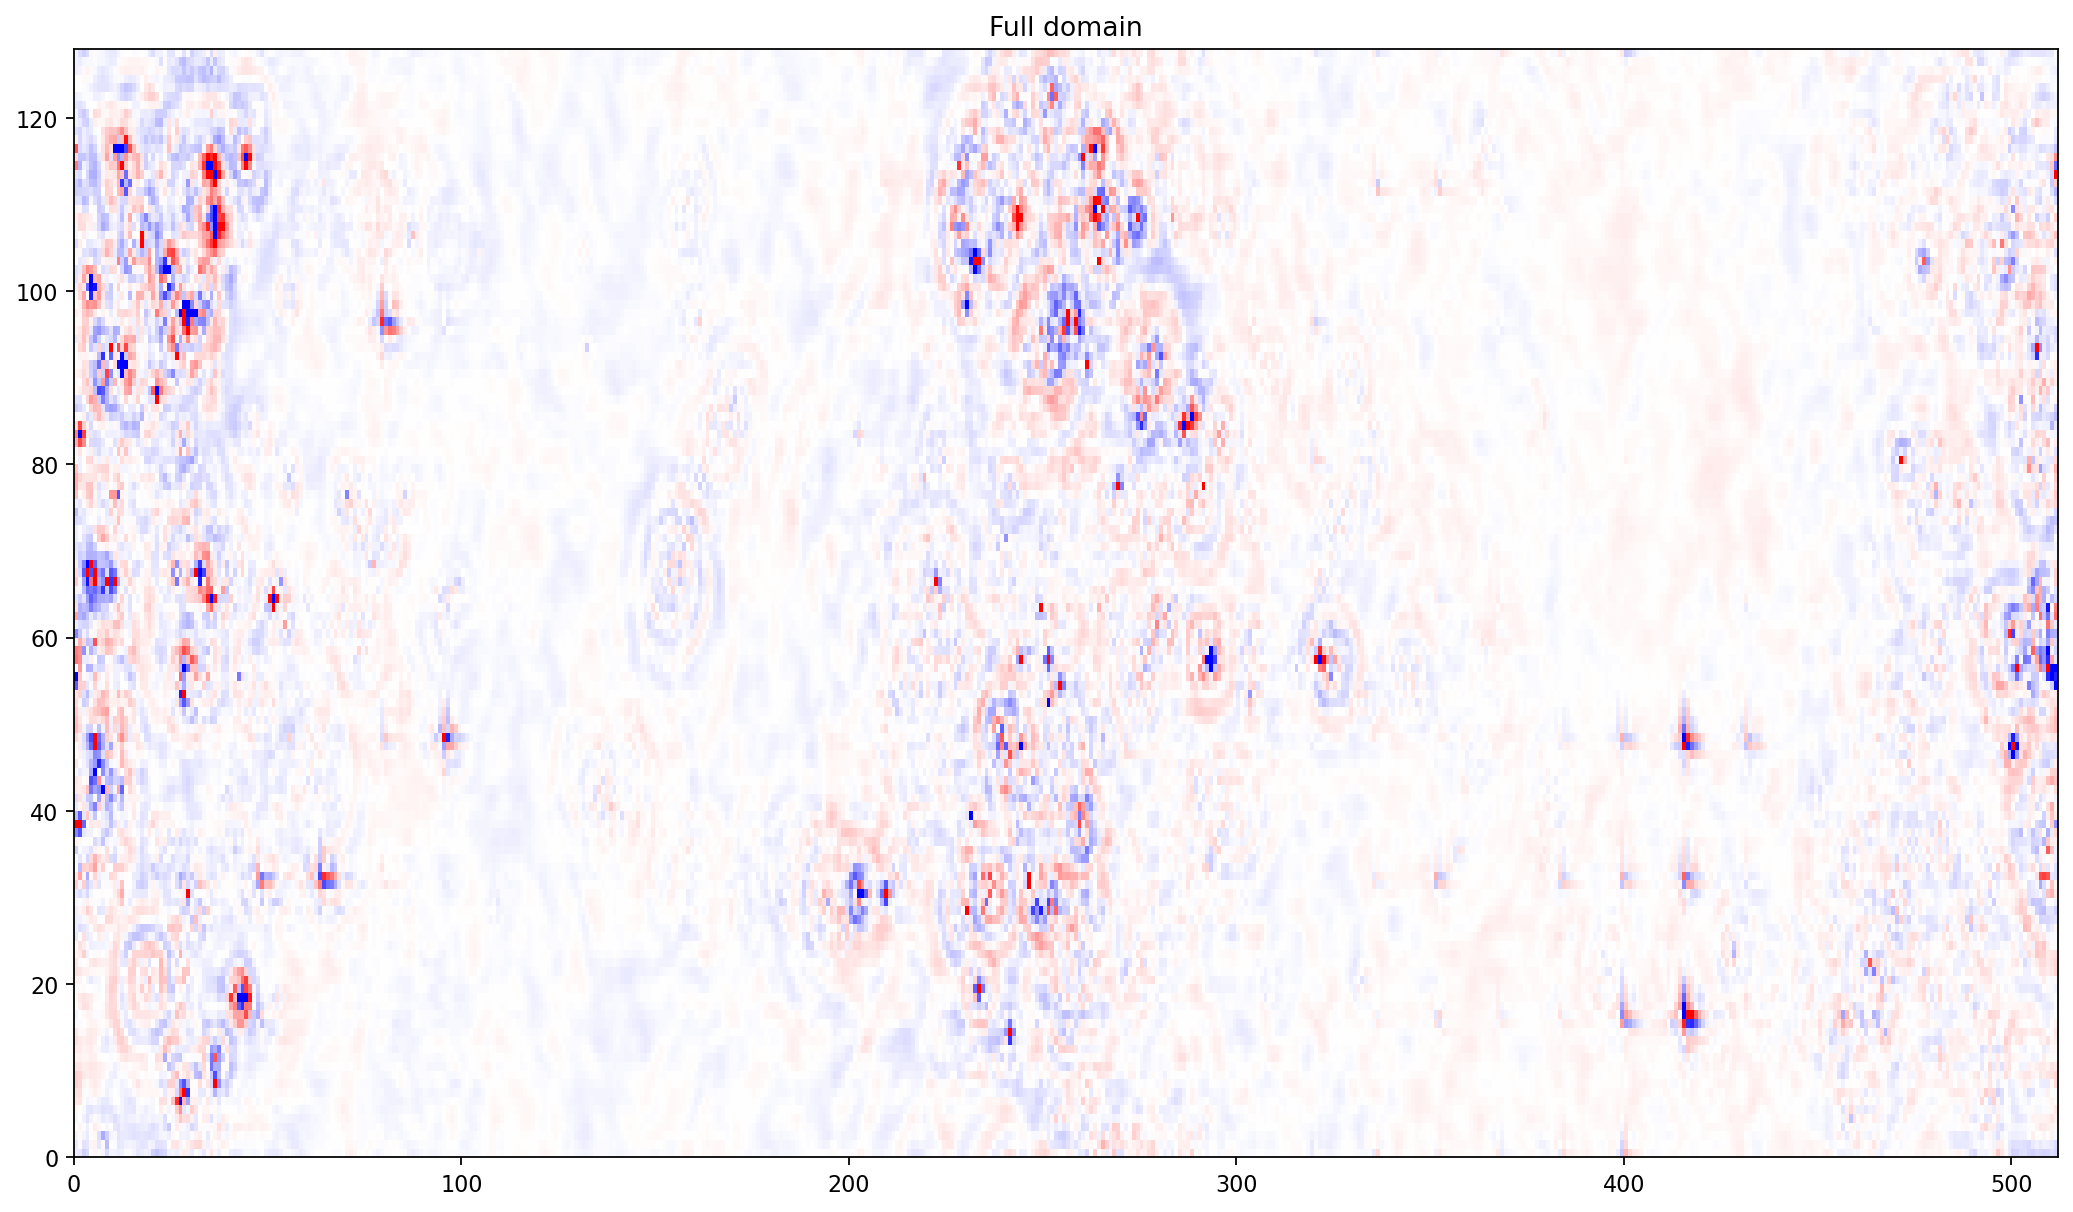

Choose x:28 y:97


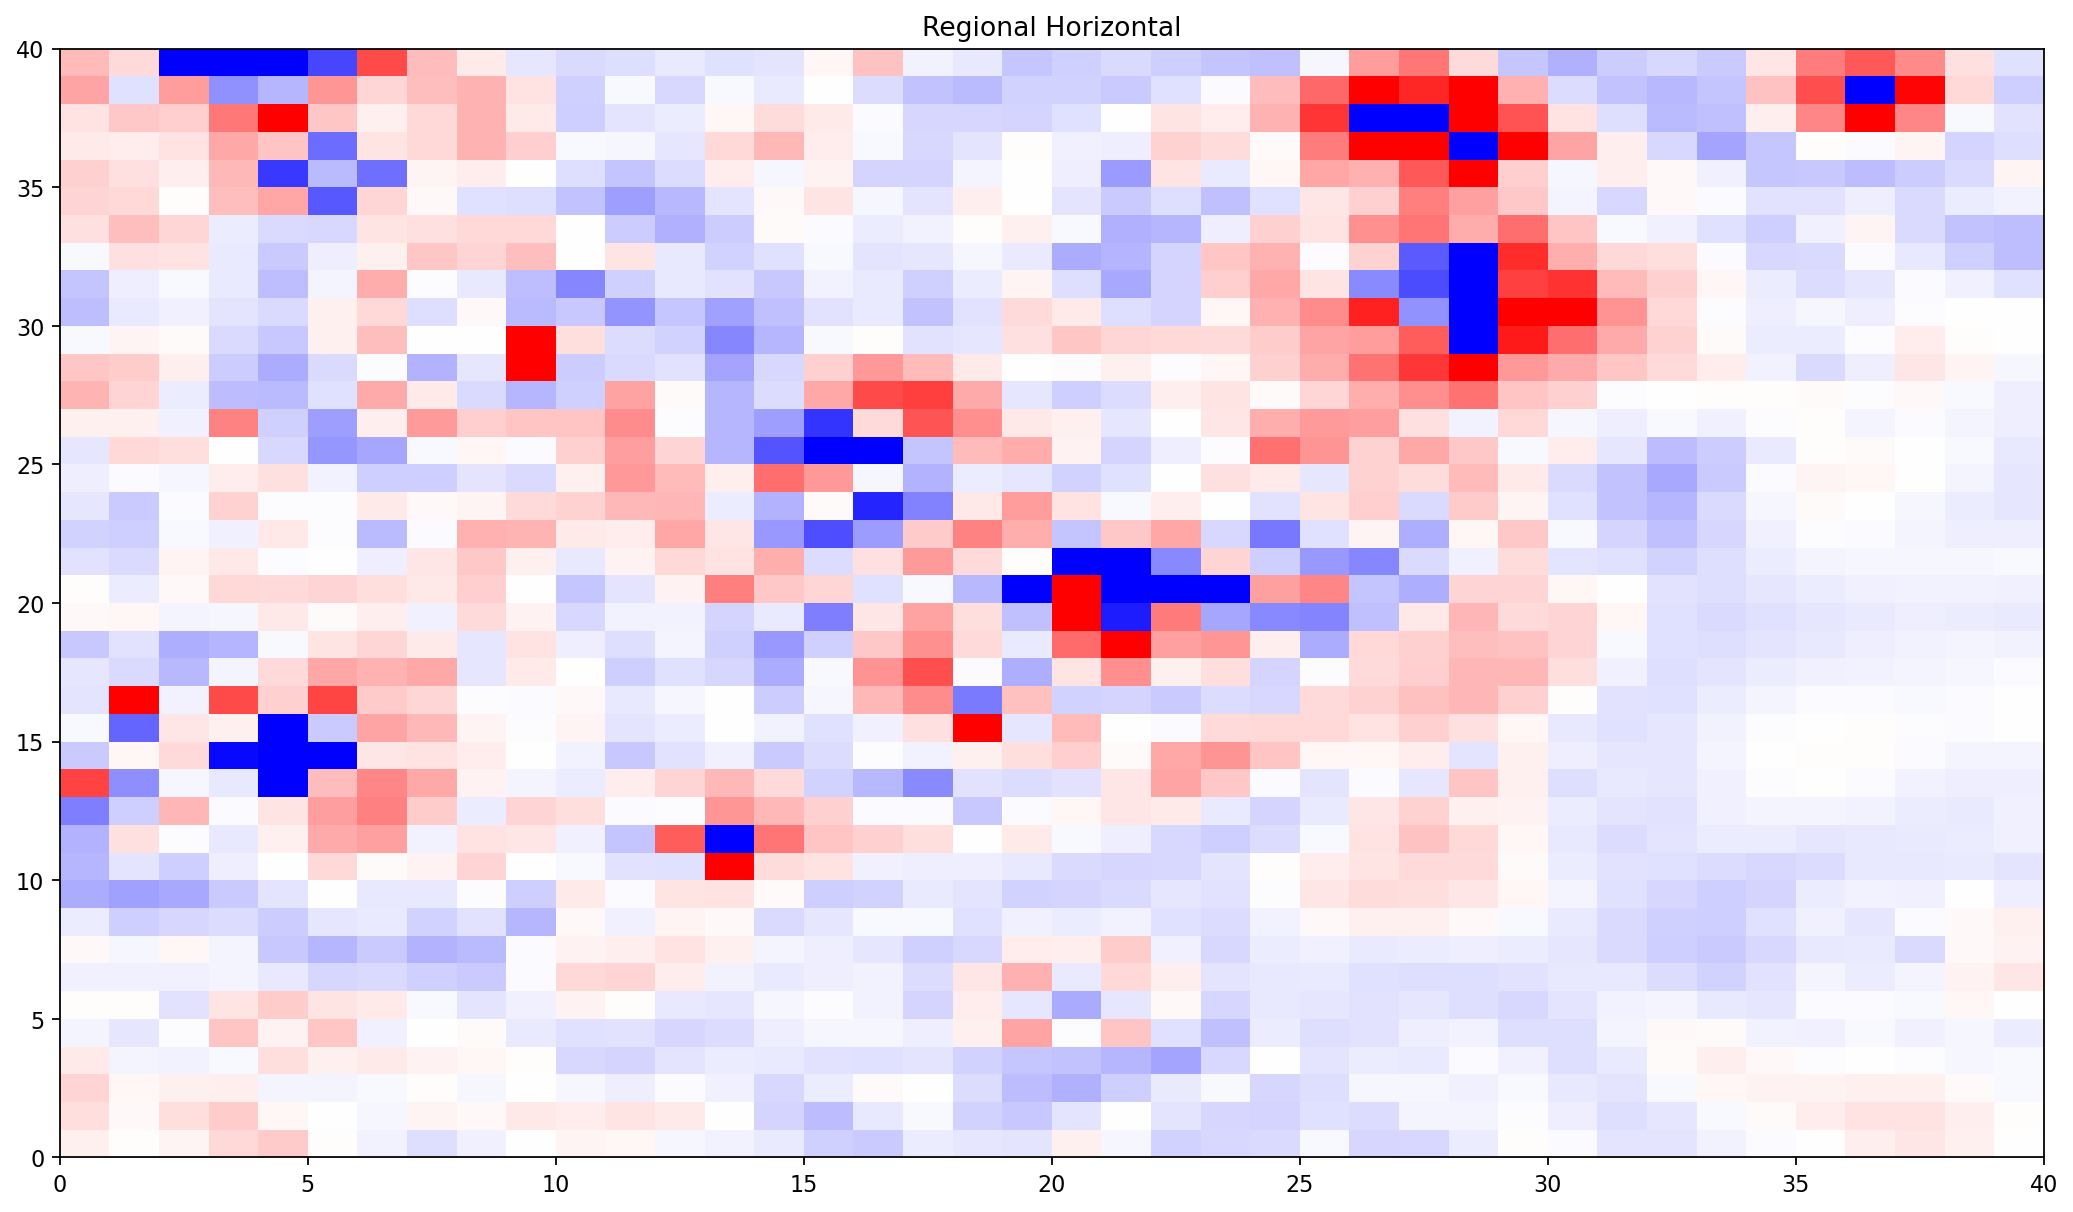

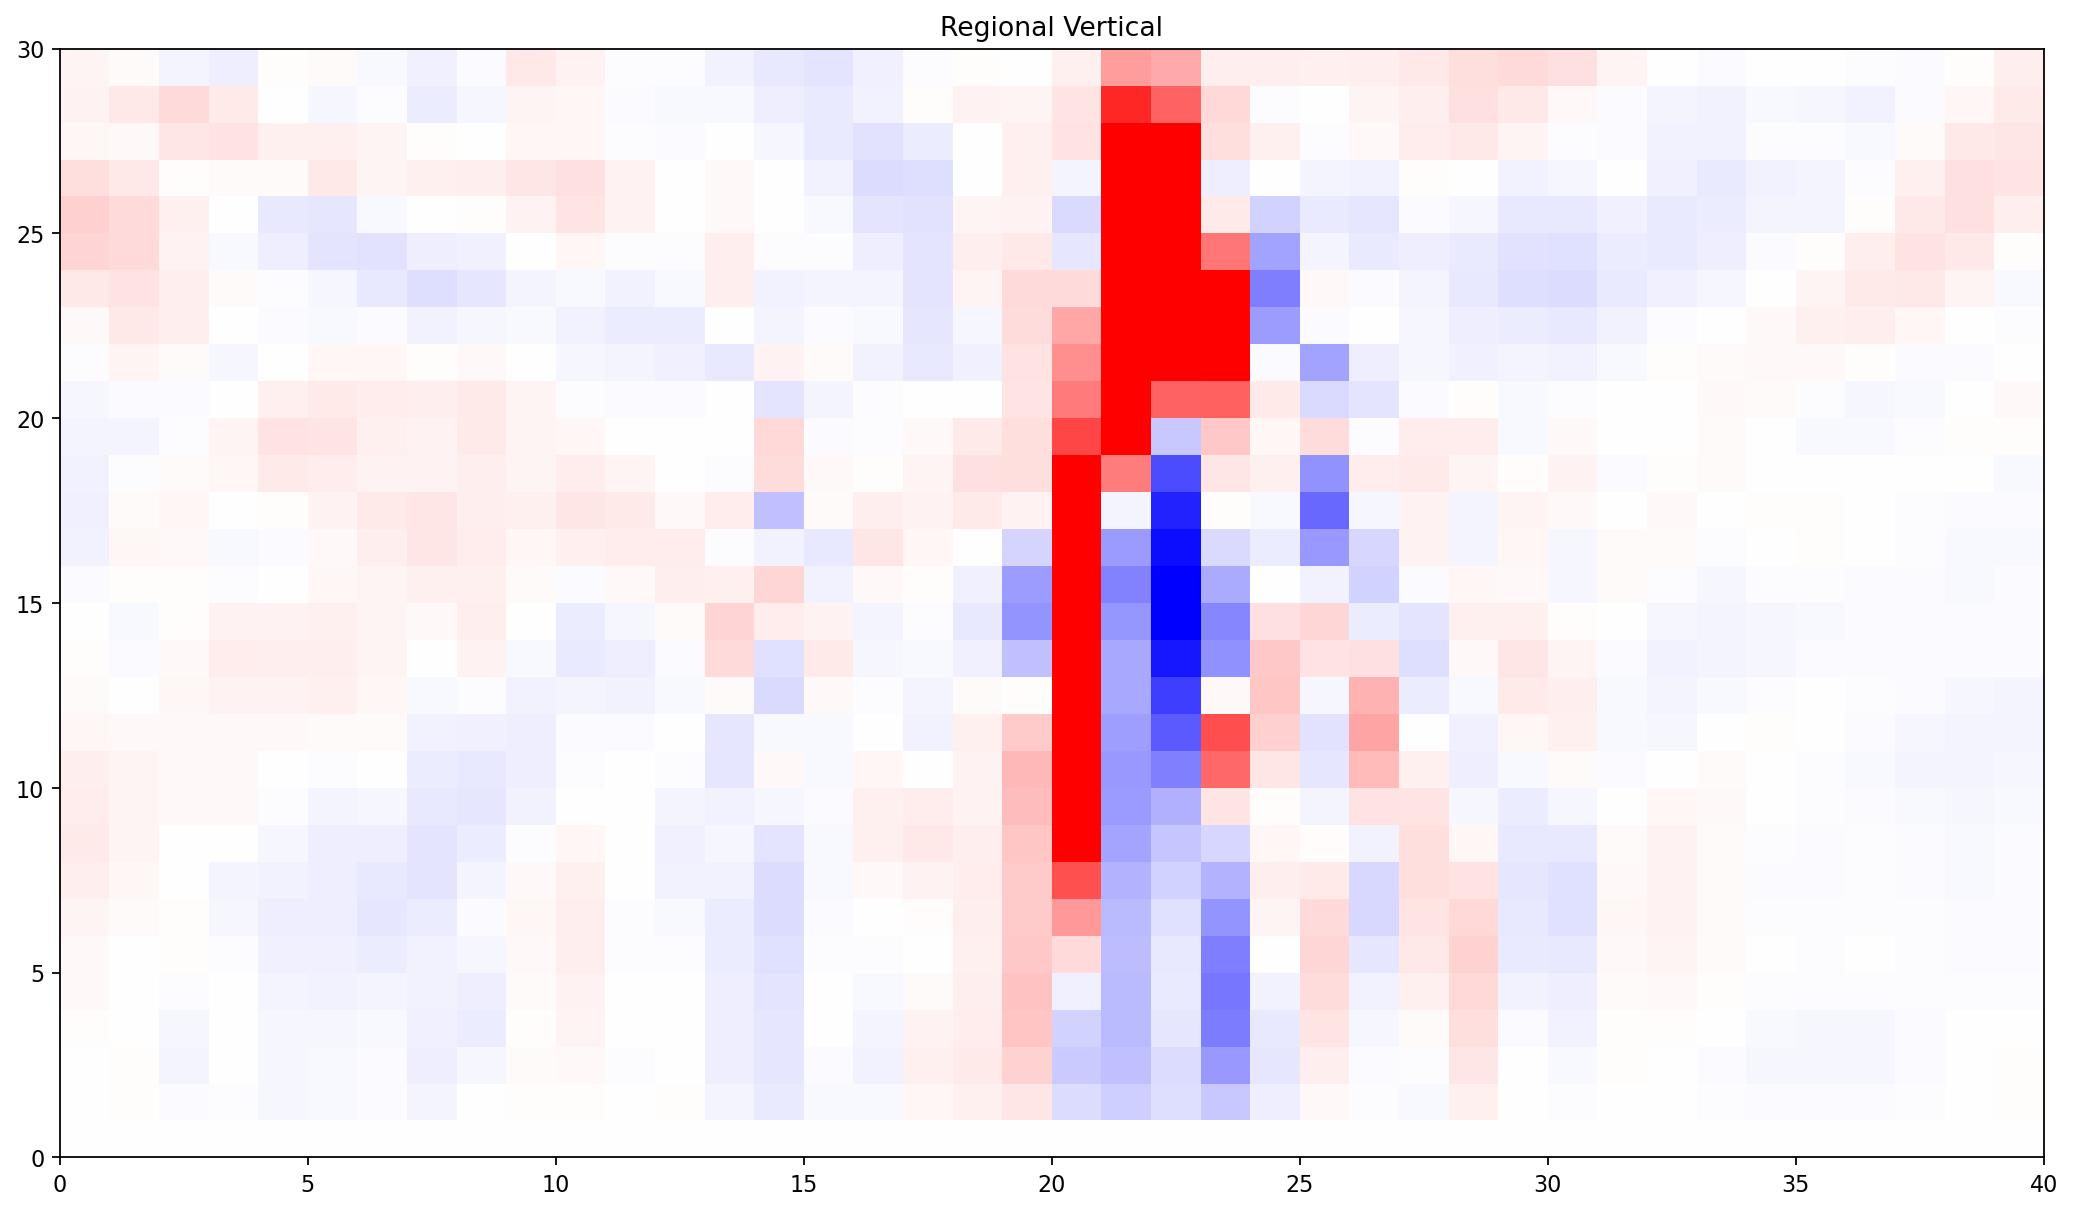

In [213]:
# Choose regional data
# By maximum vertical velocity at given level
temp = np.where(w[p_level]==w[p_level].max())
xloc = temp[1][0]
yloc = temp[0][0]

# Choose horizontal scale 
# By index
hscale = 20

# Choose vertical scale 
# By index
vscale = 30

plt.figure(figsize = (16, 9),
           dpi = 160)
plt.pcolormesh(w[p_level], vmin = -1, vmax = 1, cmap = "bwr")
# plt.contourf(w[p_level], cmap = "bwr", levels = np.linspace(-1,1,32), extend = "both")
plt.title("Full domain")
plt.show()
print(f"Choose x:{xloc} y:{yloc}")
plt.figure(figsize = (16, 9),
           dpi = 160)
plt.pcolormesh(w[p_level,yloc-hscale:yloc+hscale,xloc-hscale:xloc+hscale], 
               vmin = -1, vmax = 1, cmap = "bwr")
plt.title("Regional Horizontal")
plt.show()
plt.figure(figsize = (16, 9),
           dpi = 160)
plt.pcolormesh(w[:vscale,yloc,xloc-hscale:xloc+hscale], 
               vmin = -3, vmax = 3, cmap = "bwr")
plt.title("Regional Vertical")
plt.show()

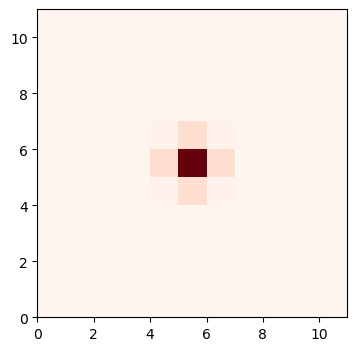

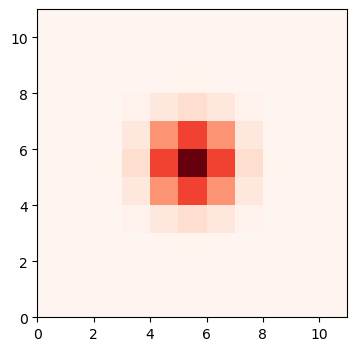

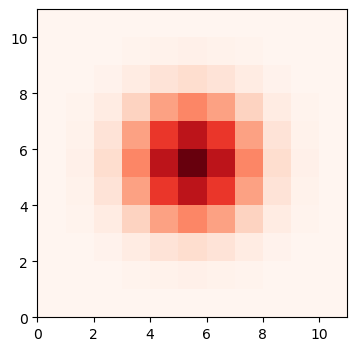

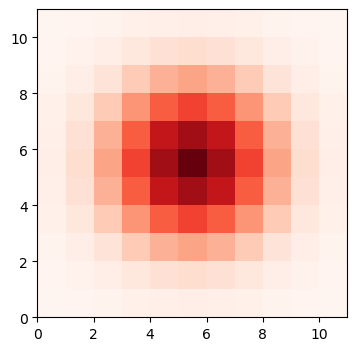

In [194]:
# Convolution kernel
sigmas = [1,2,3,4]
_ = np.linspace(-10,10,11)
xx,zz = np.meshgrid(_, _)
kernels = np.zeros((len(sigmas), 11, 11))

for i, sigma in enumerate(sigmas):
    kernels[i] = (0.5/np.pi/sigma**2) * np.exp(-(xx**2+zz**2)/(2*sigma**2))
    kernels[i] /= np.sum(kernels[i])

for i in range(len(kernels)):
    plt.figure(figsize = (4,4),
               dpi = 100)
    plt.pcolormesh(kernels[i], cmap = "Reds")
    plt.show()

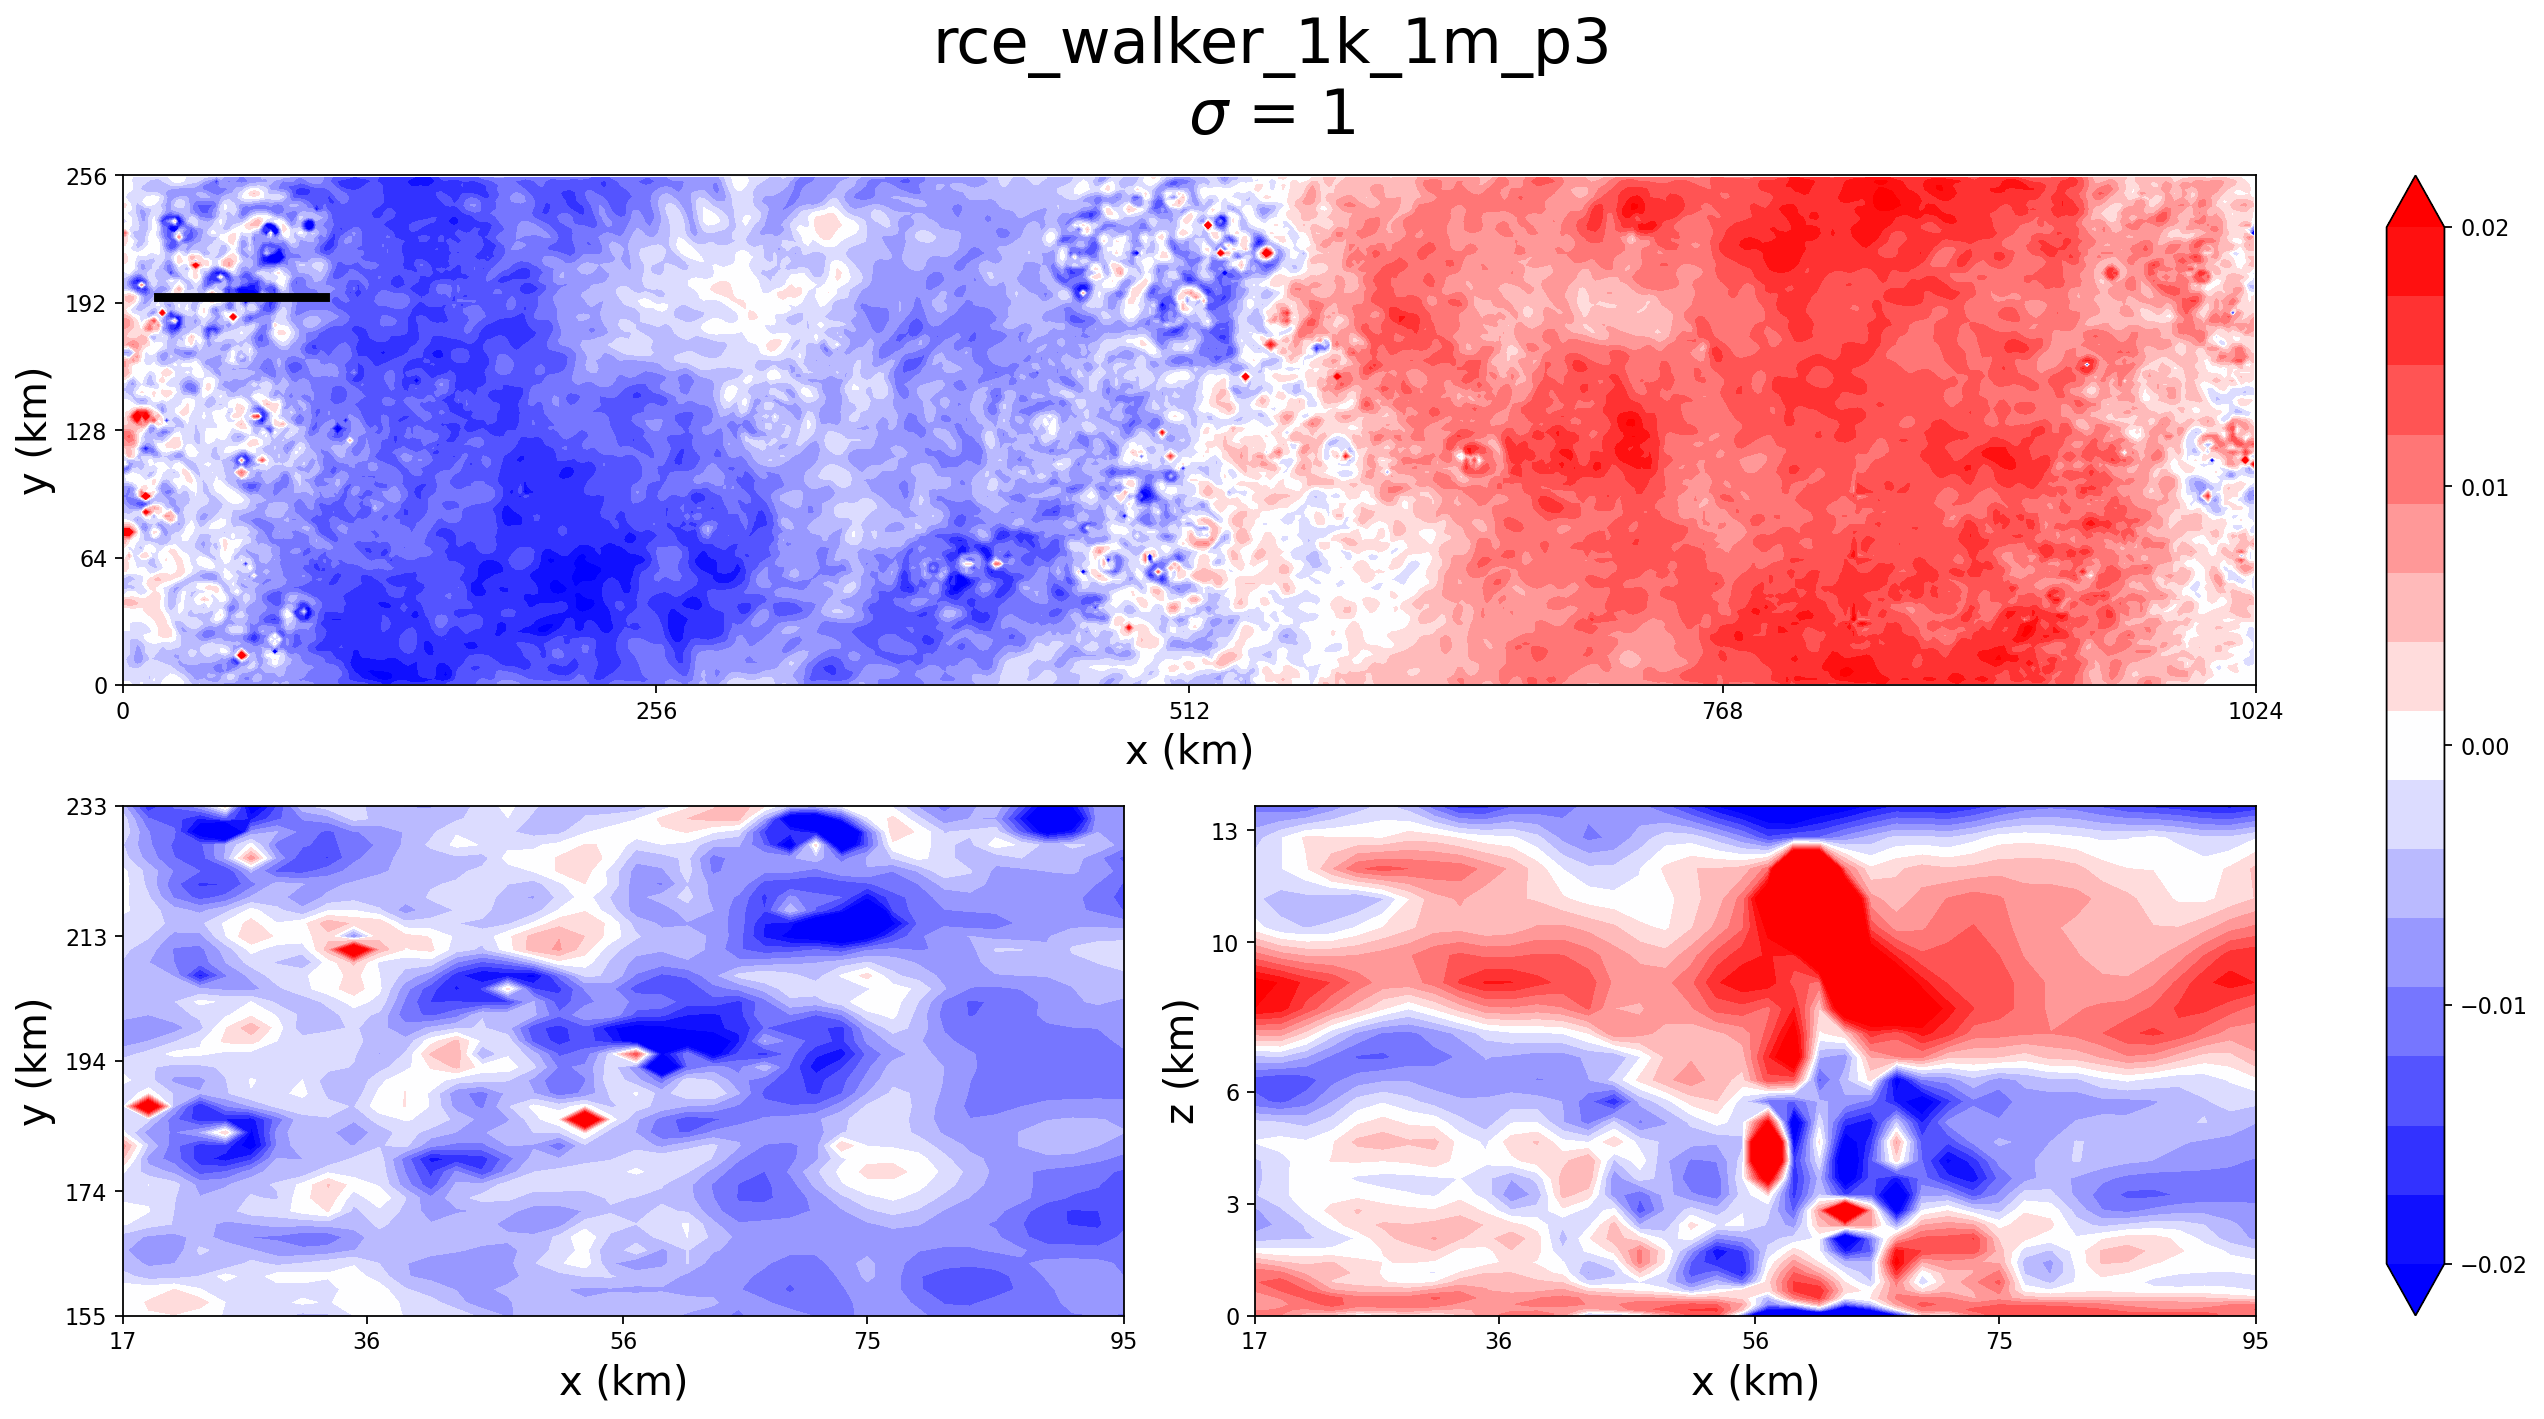

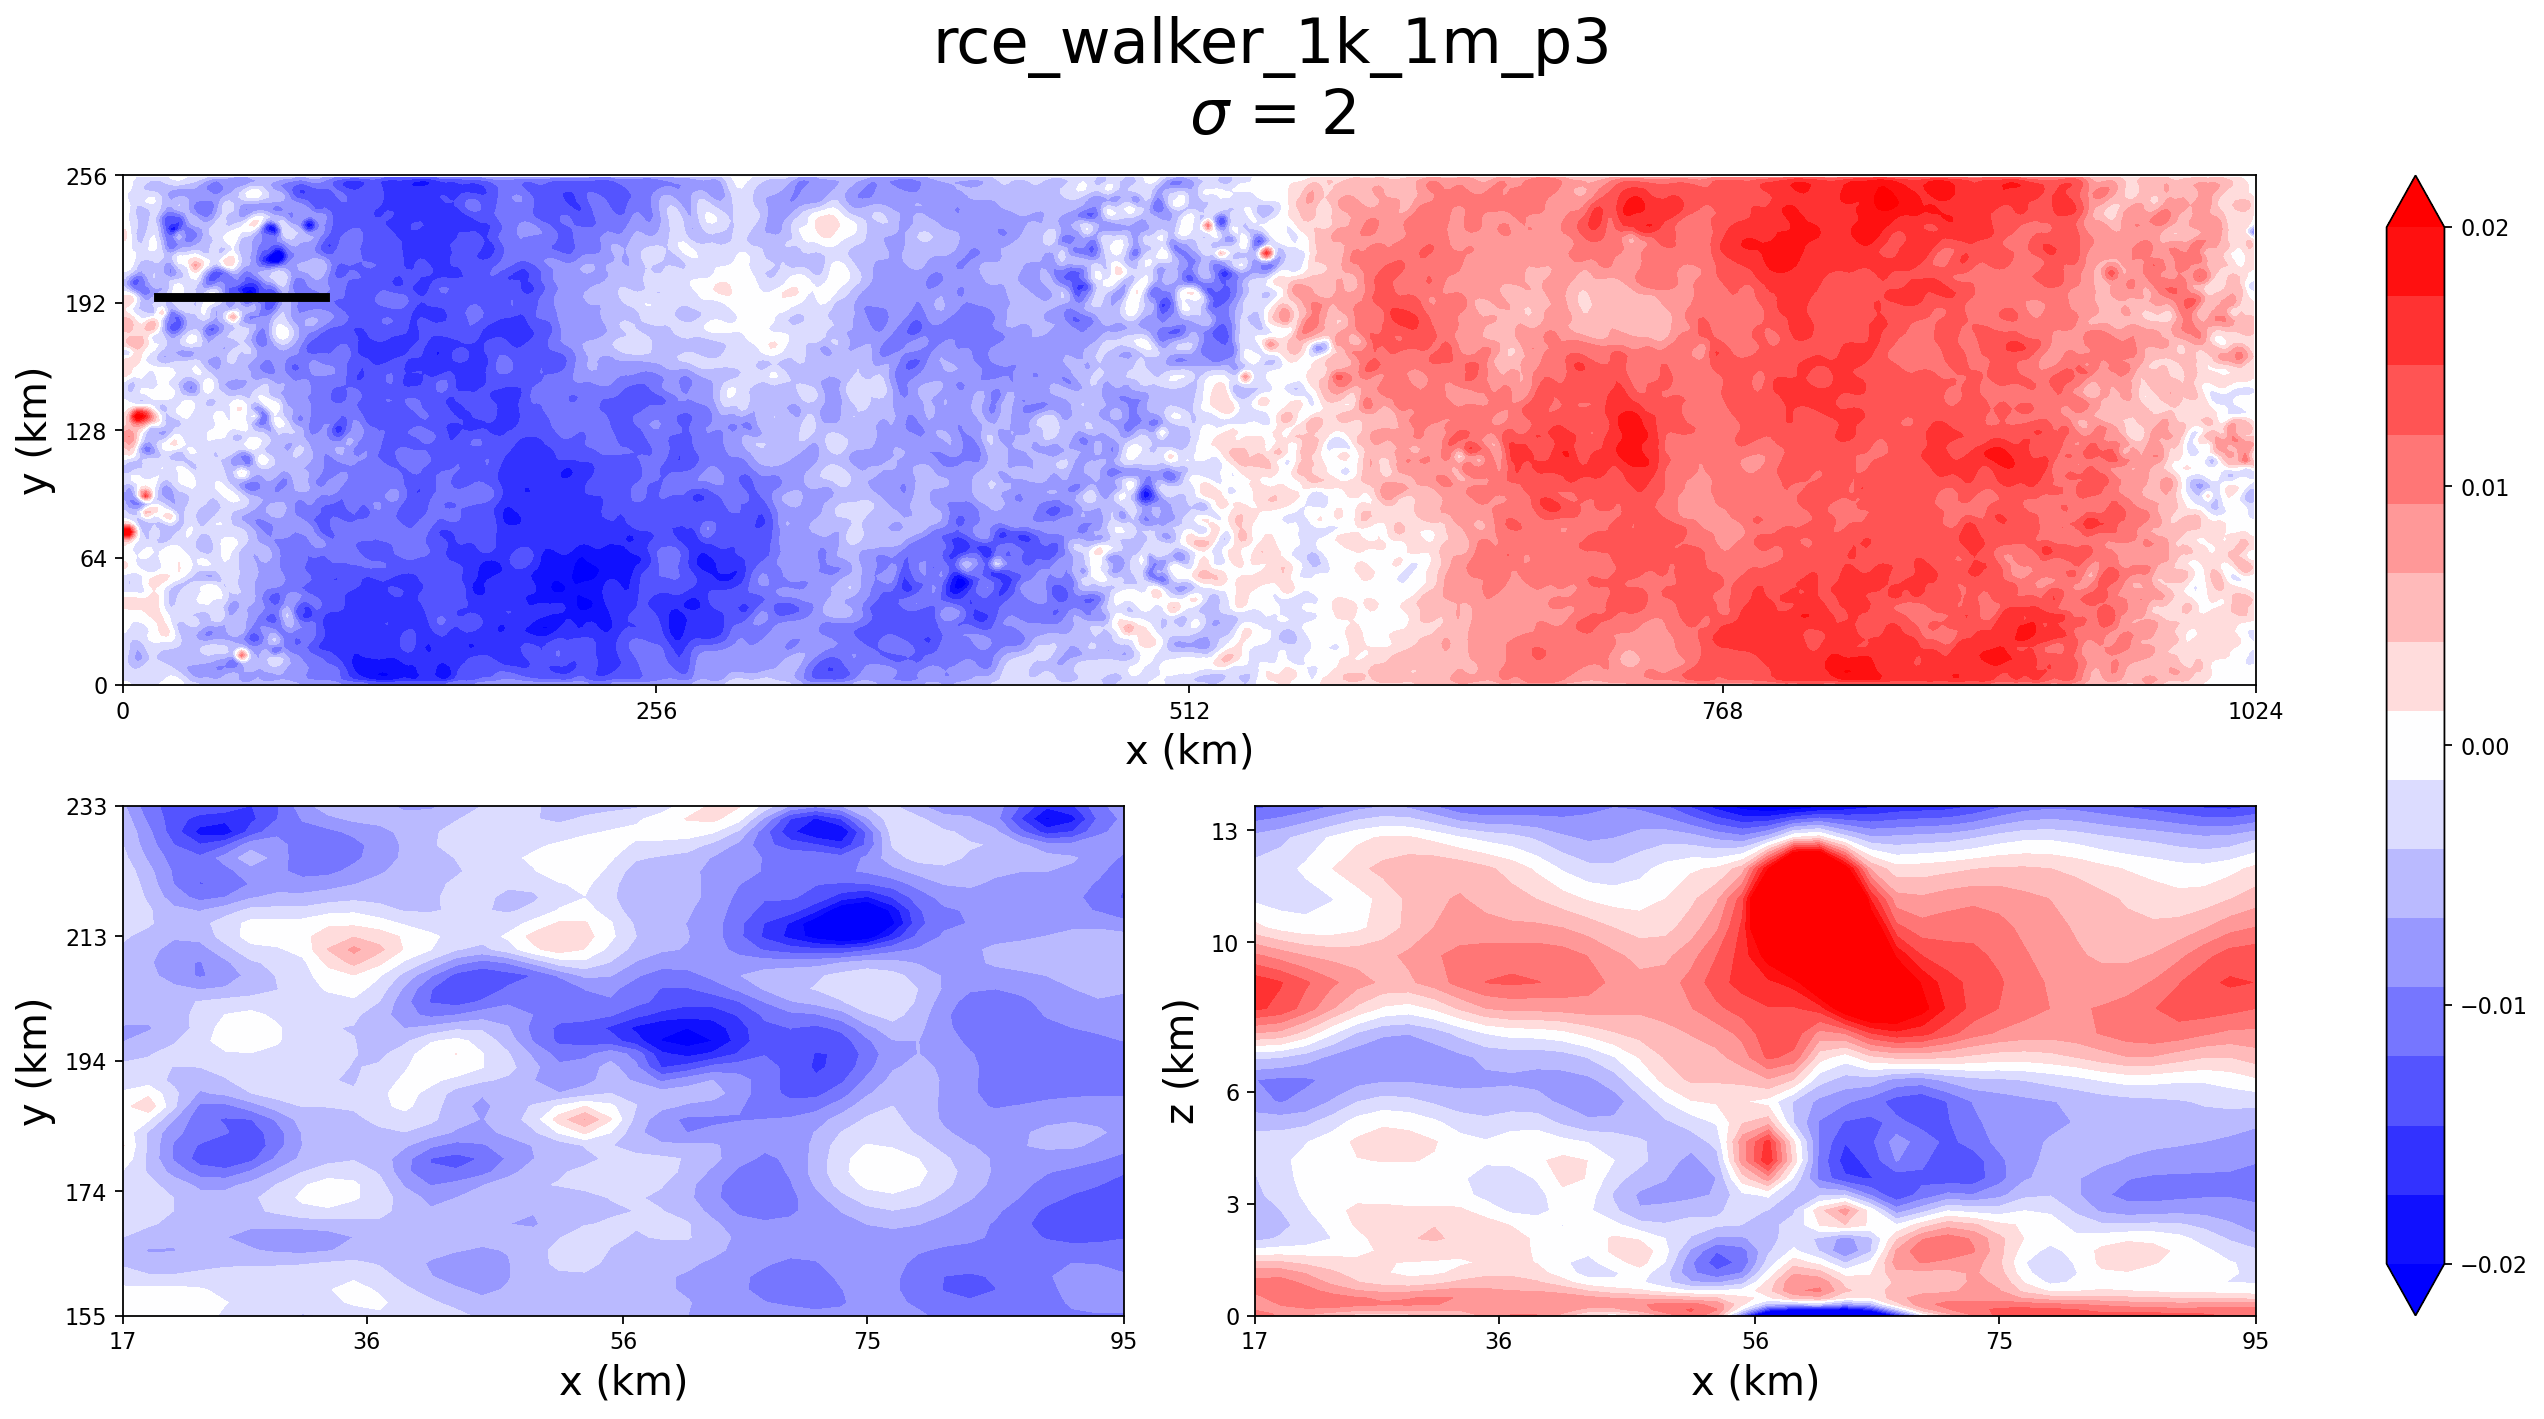

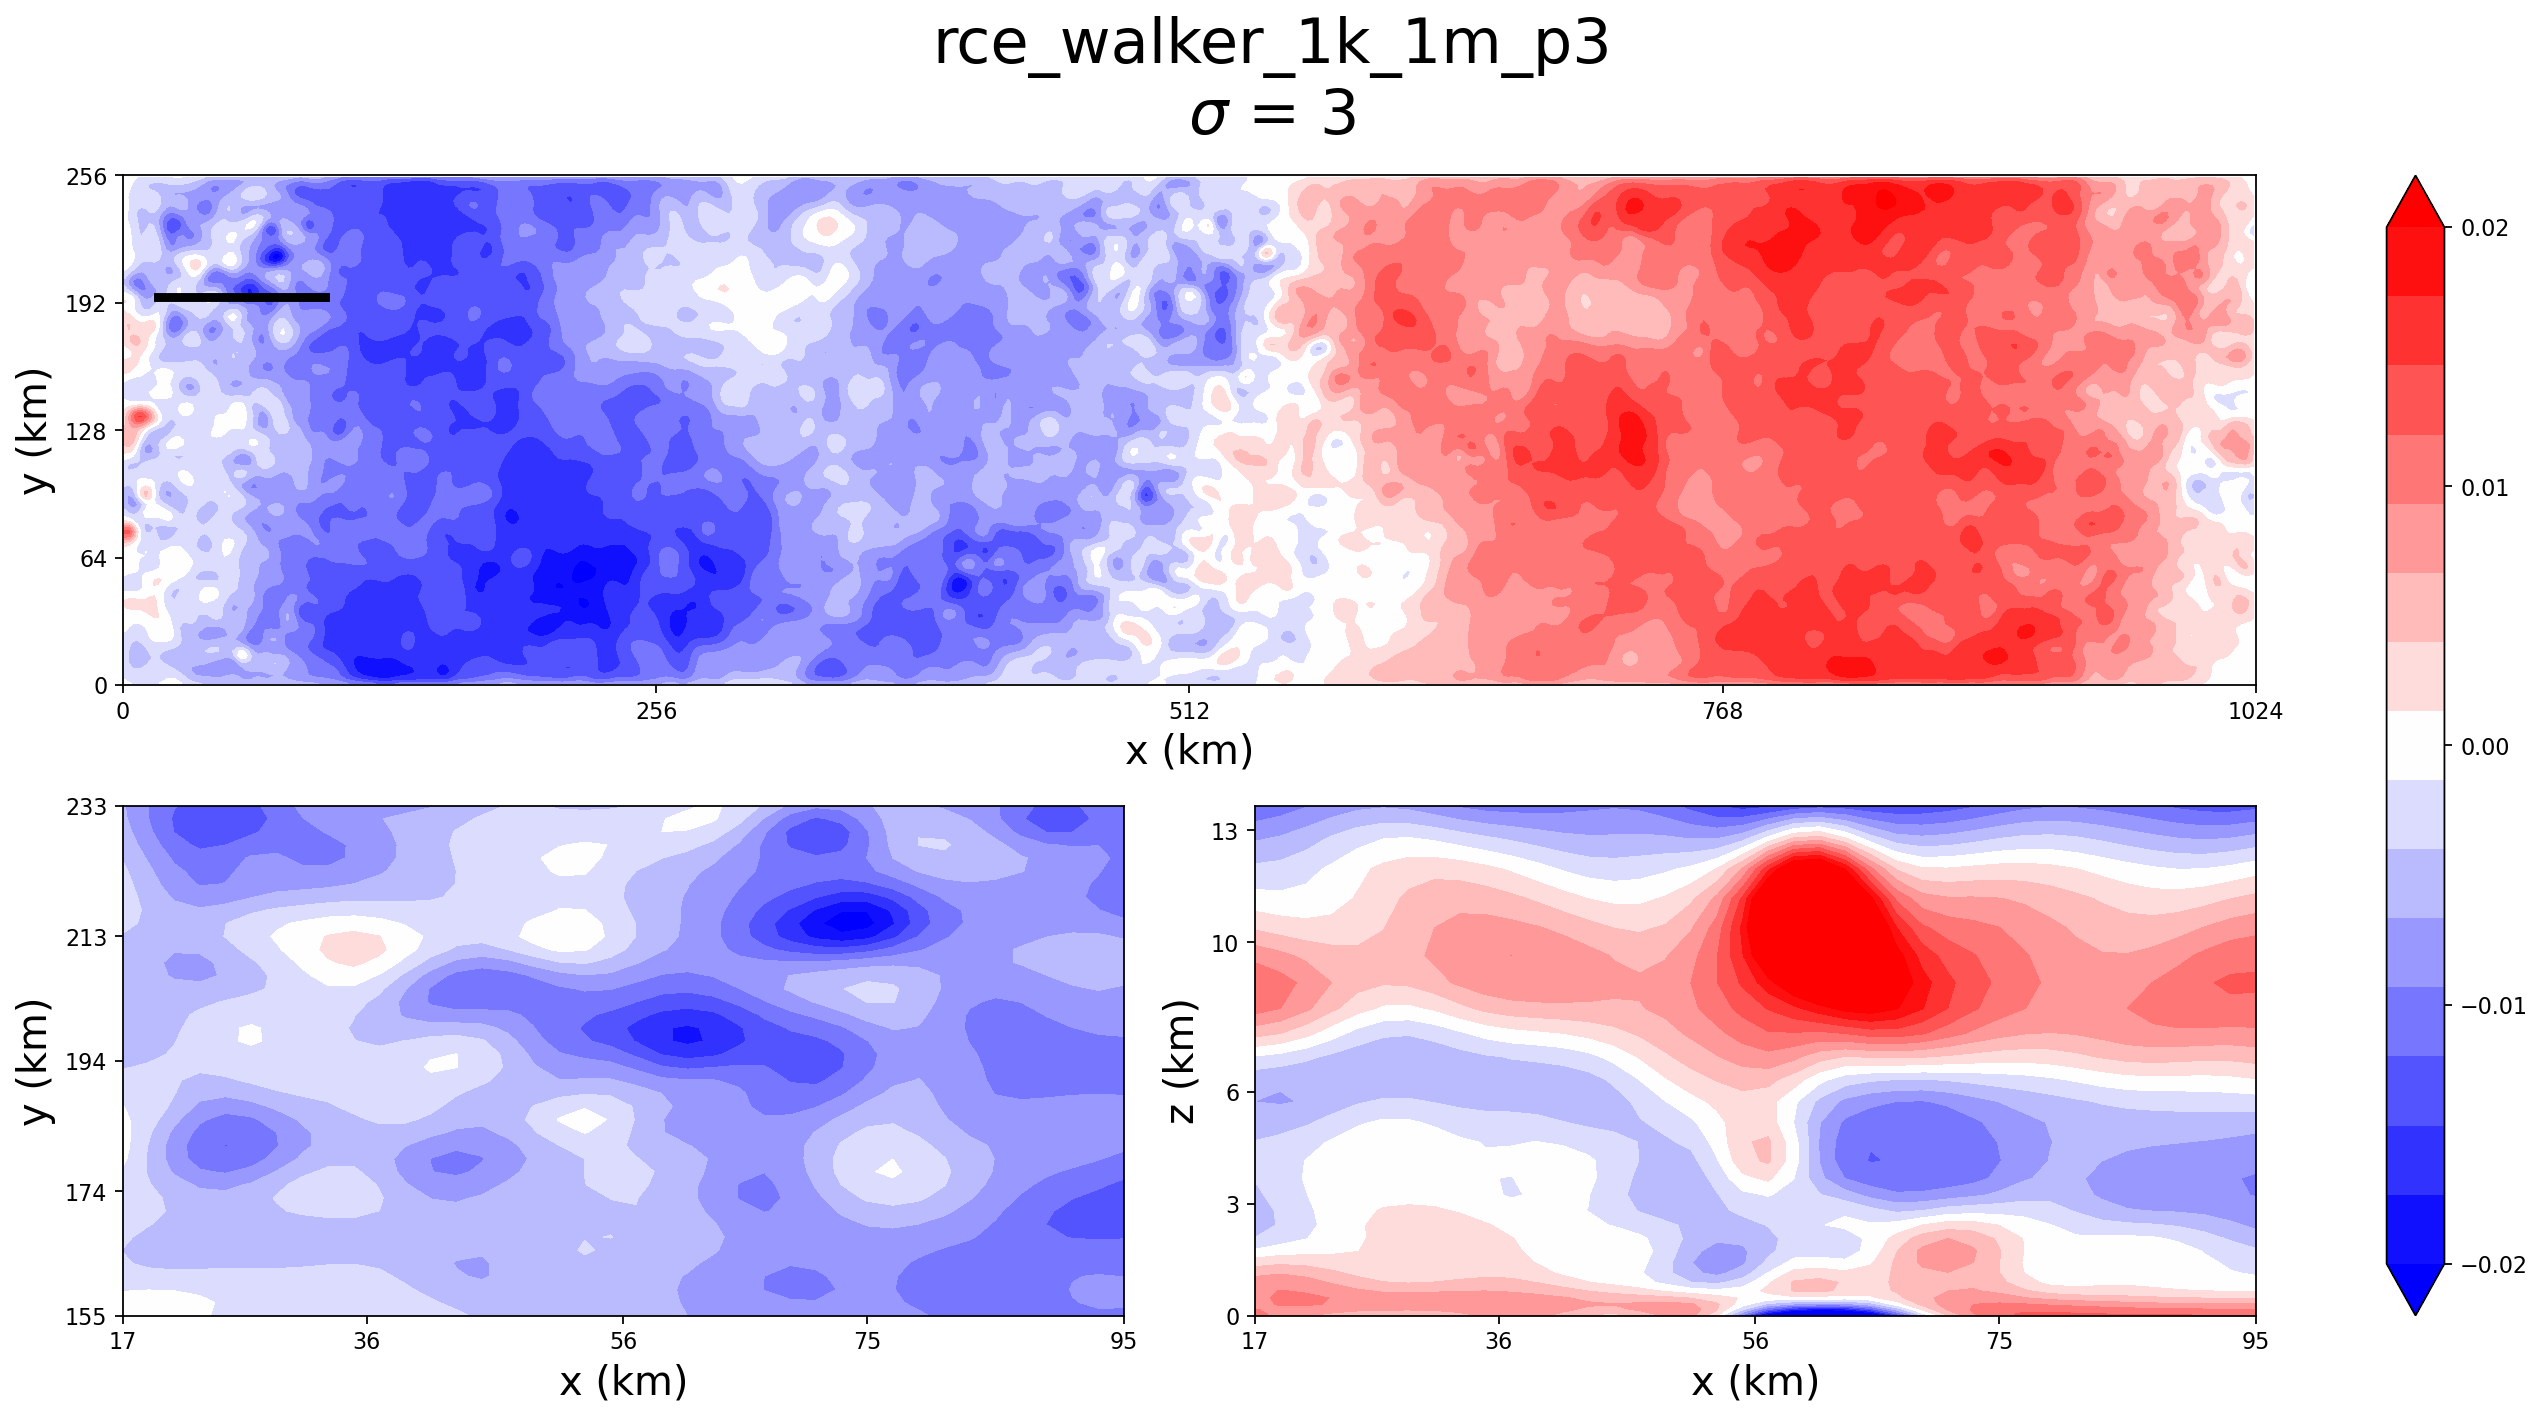

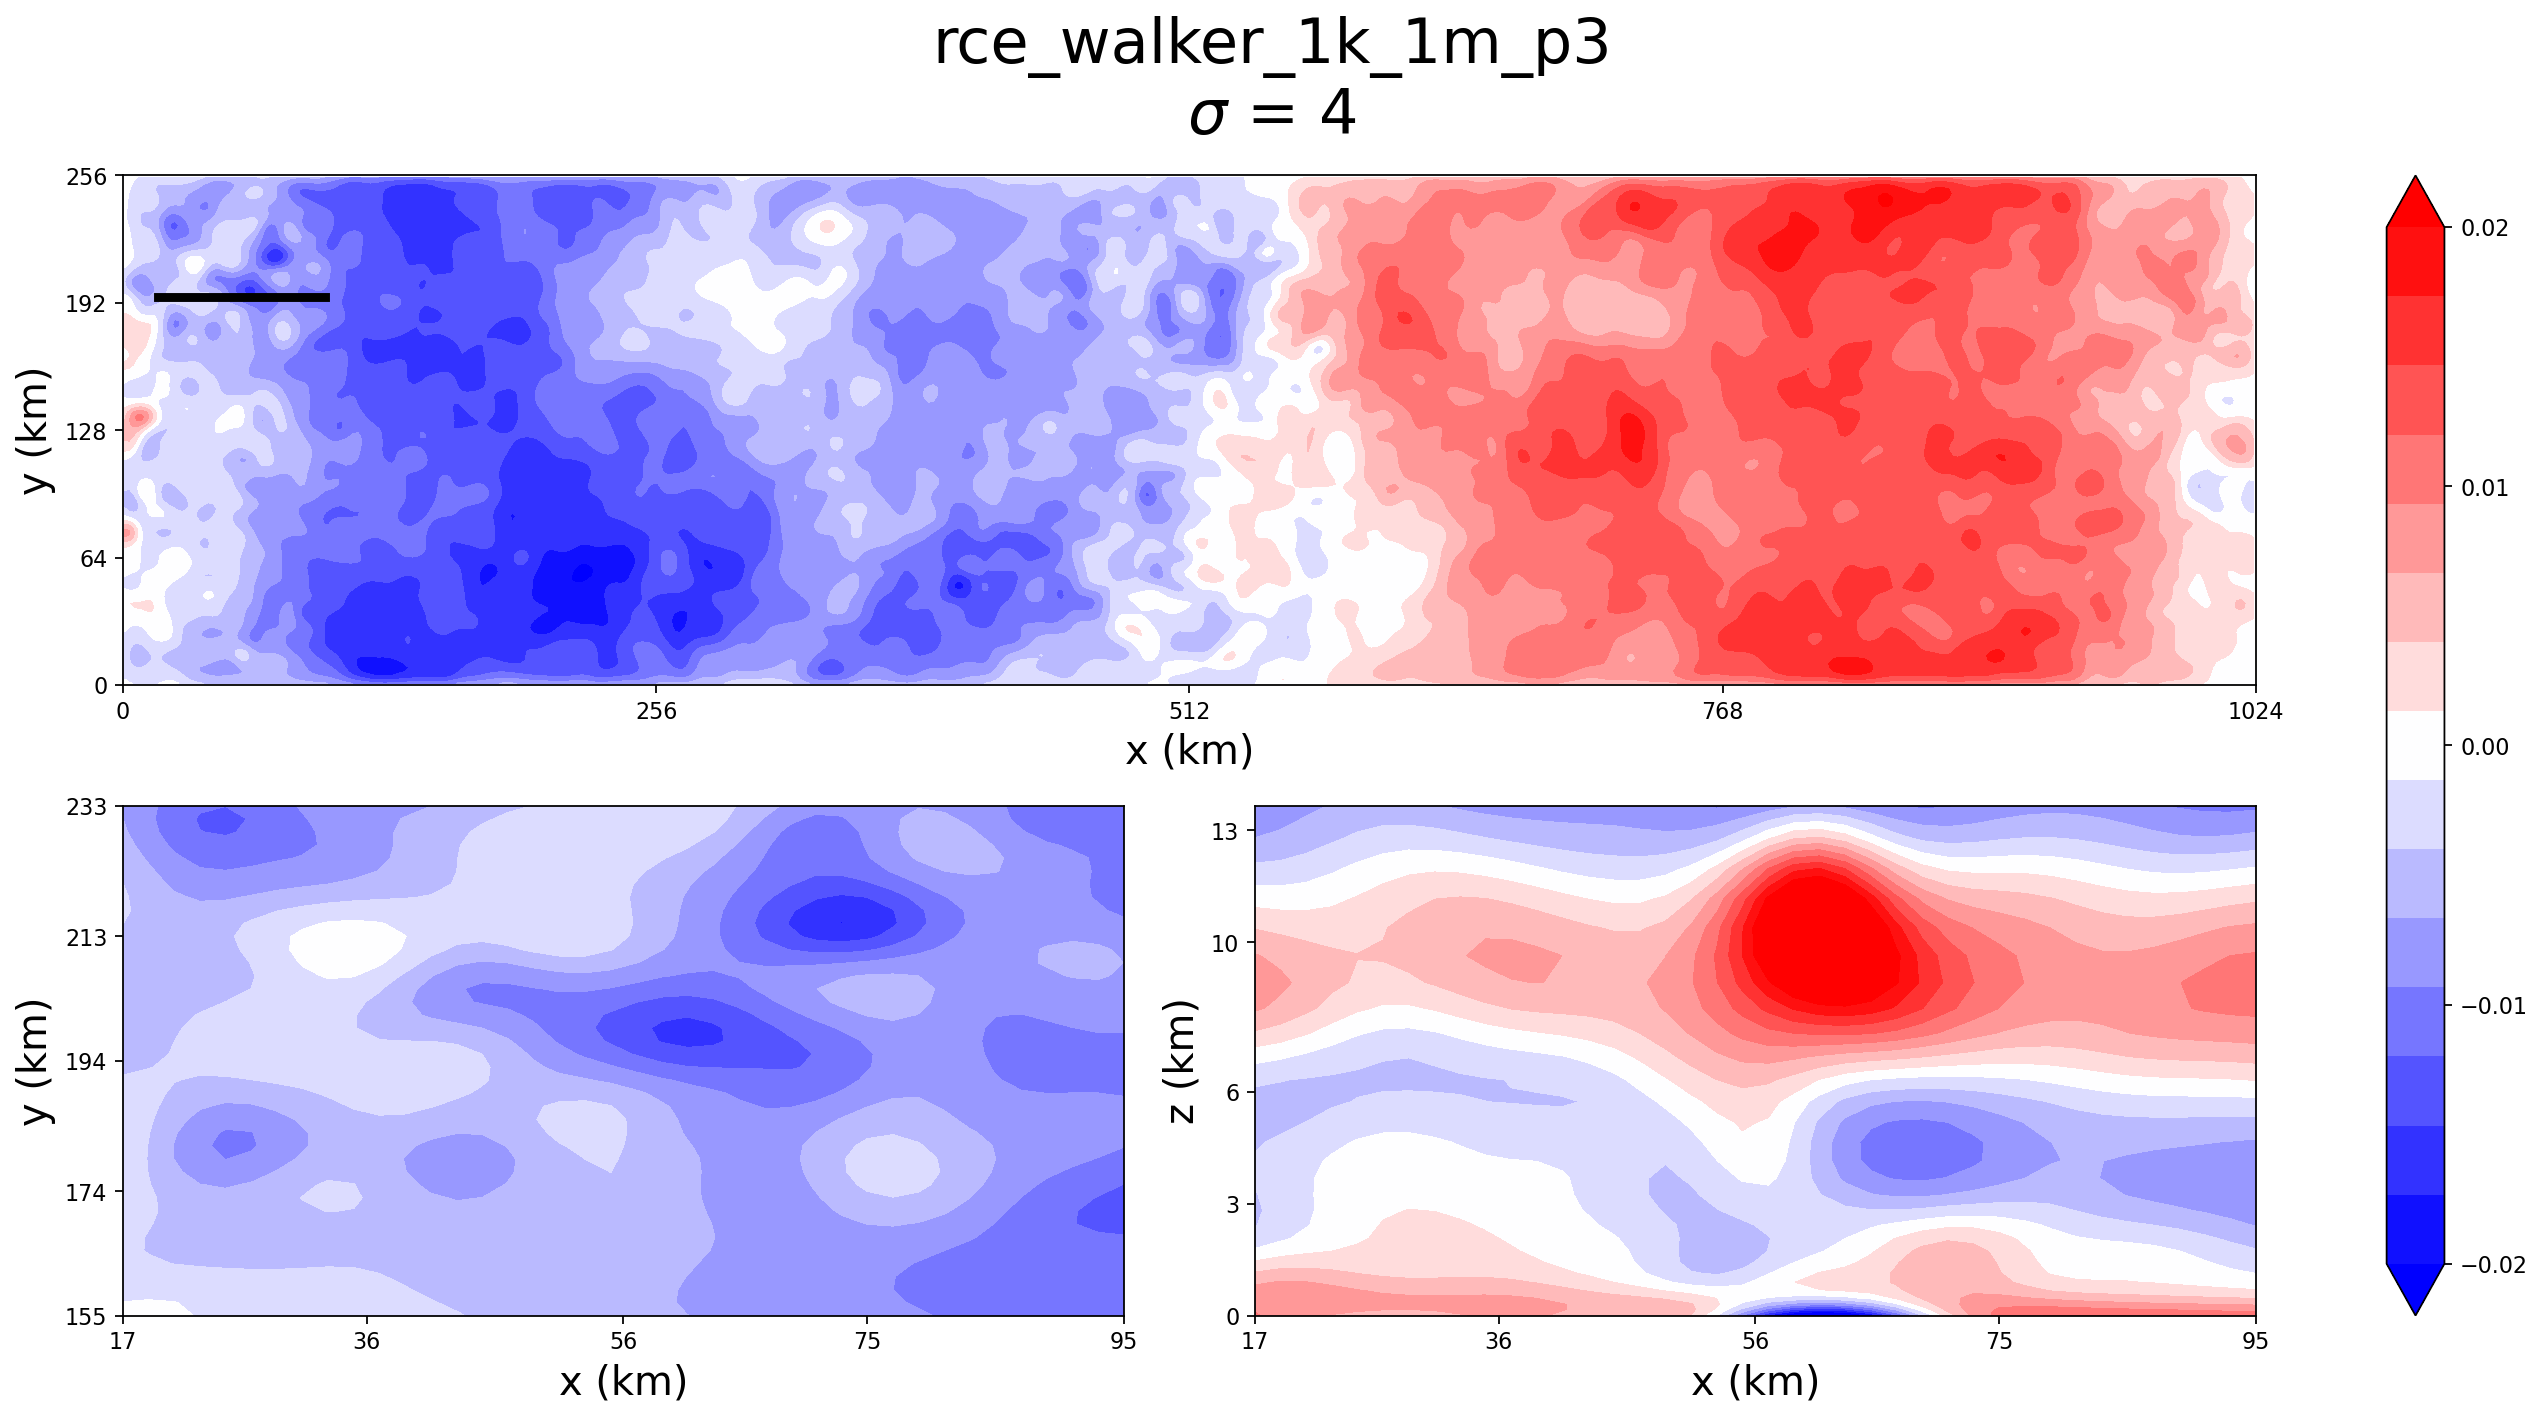

In [214]:
vname = "vertical velocity"
var = np.copy(buoy)
vmin = -0.02
vmax = 0.02
cmap = "bwr"
for i, sigma in enumerate(sigmas):
    global_coord = np.meshgrid(x/1e3, y/1e3)
    global_image = scipy.signal.correlate(var[p_level],
                                          kernels[i], 
                                          mode = 'same', 
                                          method = 'fft')
    regional_coord = np.meshgrid(x[xloc-hscale:xloc+hscale]/1e3, y[yloc-hscale:yloc+hscale]/1e3)
    regional_image = global_image[yloc-hscale:yloc+hscale, xloc-hscale:xloc+hscale]
    
    temp = scipy.signal.correlate2d(var[:,yloc,:],
                                    kernels[i], 
                                    mode = 'same',
                                    boundary = "symm")
    vertical_coord = np.meshgrid(x[xloc-hscale:xloc+hscale]/1e3, z[:vscale]/1e3)
    vertical_image = temp[:vscale,xloc-hscale:xloc+hscale]
    # vertical_coord = np.meshgrid(x/1e3, z[:vscale]/1e3)
    # vertical_image = temp[:vscale,:]
    
    fig = plt.figure(figsize = (16,9),
                     dpi = 160)
    gs = fig.add_gridspec(2,13)
    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :6])
    ax3 = fig.add_subplot(gs[1, 6:12])
    ax4 = fig.add_subplot(gs[:, 12])
    axes = [ax1,ax2,ax3,ax4]

    for i, ax in enumerate(axes):
        if i==0:
            ax.plot([x[xloc-hscale]/1e3, x[xloc+hscale]/1e3],
                    [y[yloc]/1e3, y[yloc]/1e3], "k-", linewidth = 4)
            im = ax.contourf(global_coord[0], global_coord[1], global_image,
                             levels = np.linspace(vmin, vmax, 16),
                             cmap = cmap, extend = "both")
            ax.set_xticks(np.linspace(0, 1024, 5, dtype = np.int64))
            ax.set_yticks(np.linspace(0, 256, 5, dtype = np.int64))
            ax.set_xlabel("x (km)", fontsize = 18)
            ax.set_ylabel("y (km)", fontsize = 18)
            
        elif i==1:
            ax.contourf(regional_coord[0], regional_coord[1], regional_image, 
                        levels = np.linspace(vmin, vmax, 16),
                        cmap = cmap, extend = "both")
            ax.set_xticks(np.linspace(regional_coord[0][0,0], 
                                      regional_coord[0][0,-1], 
                                      num = 5, 
                                      dtype = np.int64))
            ax.set_yticks(np.linspace(regional_coord[1][0,0], 
                                      regional_coord[1][-1,0], 
                                      num = 5, 
                                      dtype = np.int64))
            ax.set_xlabel("x (km)", fontsize = 18)
            ax.set_ylabel("y (km)", fontsize = 18)
            
        elif i==2:
            ax.contourf(vertical_coord[0], vertical_coord[1], vertical_image, 
                        levels = np.linspace(vmin, vmax, 16),
                        cmap = cmap, extend = "both")
            ax.set_xticks(np.linspace(vertical_coord[0][0,0], 
                                      vertical_coord[0][0,-1], 
                                      num = 5, 
                                      dtype = np.int64))
            ax.set_yticks(np.linspace(vertical_coord[1][0,0], 
                                      vertical_coord[1][-1,0], 
                                      num = 5, 
                                      dtype = np.int64))
            ax.set_xlabel("x (km)", fontsize = 18)
            ax.set_ylabel("z (km)", fontsize = 18)
            
        elif i==3:
            cbar = plt.colorbar(im, cax = ax)
            cbar.set_ticks(np.linspace(vmin, vmax, 5))
    plt.suptitle(f"{casenames[case_idx][1:]}\n$\sigma$ = {round(sigma, 2)}", fontsize = 28)
    plt.tight_layout()
    plt.savefig(f"B_nonaggregate_sigma_{sigma}.png")